In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
from collections import defaultdict
sys.path.append("../4ncnn")
from data_utils import preprocess_sample

/mnt/home/dchhantyal/miniforge3/envs/ml-tf/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 805: MPS client failed to connect to the MPS control daemon or the MPS server (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
BASE_DIR = "/mnt/home/dchhantyal/3d-cnn-classification/data/nuclei_state_dataset/230212_stack6_extracted"
LABELS = ["mitotic", "new_daughter", "stable", "death"]
NUM_SAMPLES_PER_LABEL = 10


: 

In [ ]:
def plot_grid(images, ncols=4, label=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axs = axs.flatten()
    for i, img in enumerate(images):
        axs[i].imshow(np.mean(img, axis=0), cmap='gray')
        axs[i].axis('off')
        if i == 0:
            axs[i].set_title(f"{label} {img.shape}", fontsize=10)
    for i in range(len(images), len(axs)):
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()

: 

In [ ]:
# Find random labels
datapoints = defaultdict(list)

for label in LABELS:
    label_dir = os.path.join(BASE_DIR, label)
    if not os.path.exists(label_dir):
        print(f"Directory {label_dir} does not exist.")
        continue
    
    files = [f for f in os.listdir(label_dir)]
    if not files:
        print(f"No files found in {label_dir}.")
        continue

    datapoints[label] = np.random.choice(files, NUM_SAMPLES_PER_LABEL, replace=False)


: 

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


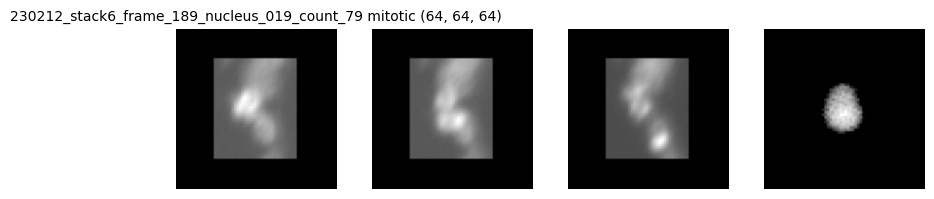

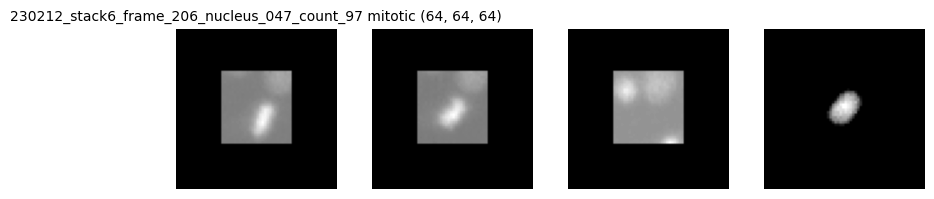

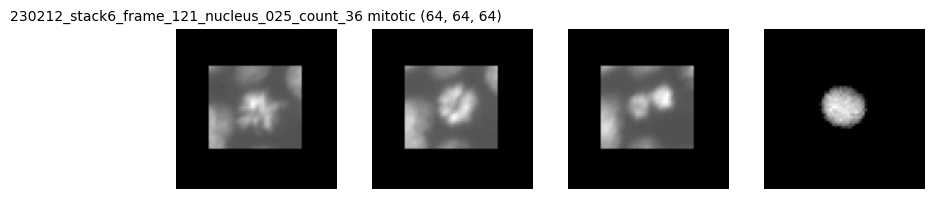

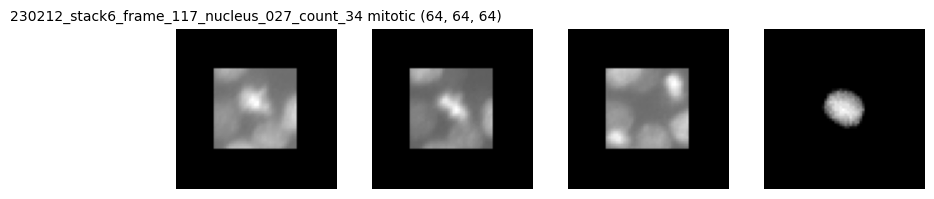

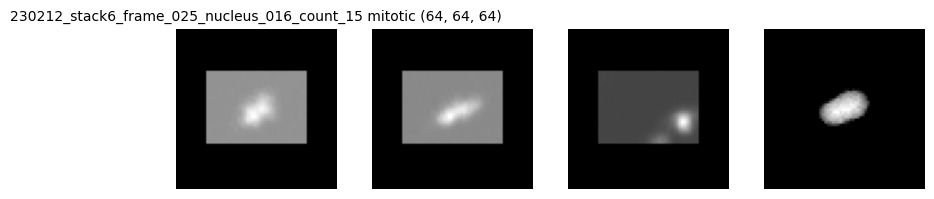

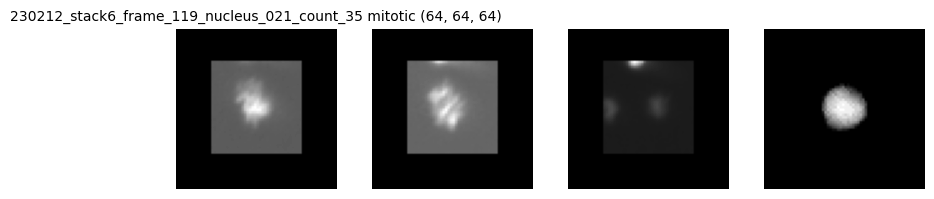

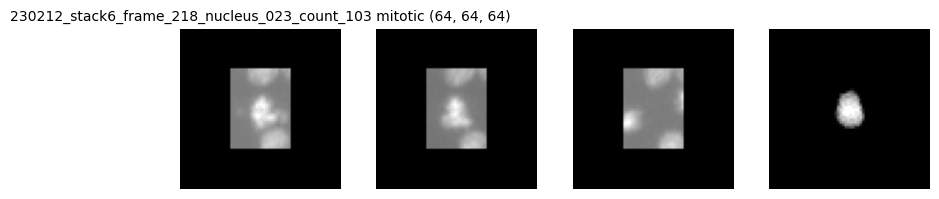

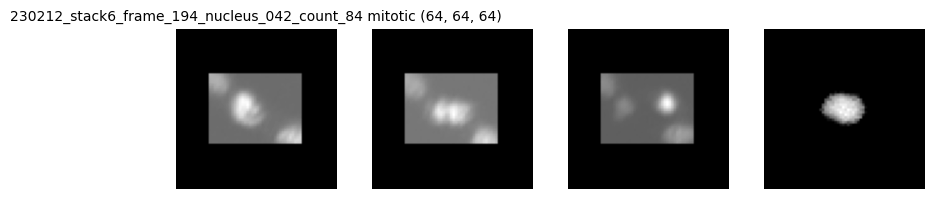

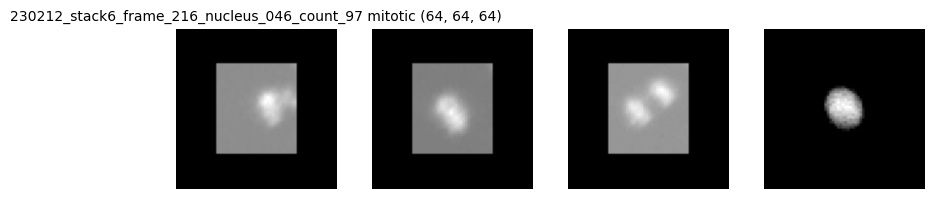

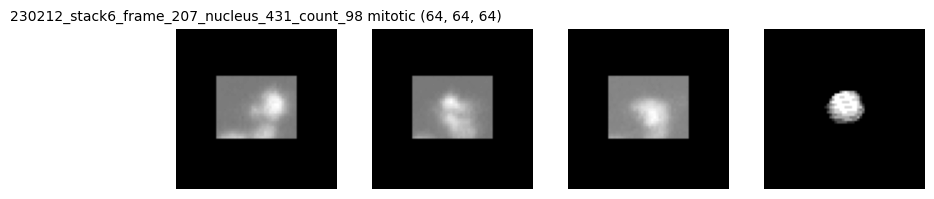

In [11]:
# MITOTIC
for file_path in datapoints["mitotic"]:
    folder_path = os.path.join(BASE_DIR, "mitotic", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path, save_analysis=False,
    )
    
    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'mitotic'}")

In [ ]:
# NEW DAUGHTER
for file_path in datapoints["new_daughter"]:
    folder_path = os.path.join(BASE_DIR, "new_daughter", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path,
        save_analysis=False,
    )

    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'new_daughter'}")

NameError: name 'datapoints' is not defined

: 

: 

In [5]:
# STABLE
for file_path in datapoints["stable"]:
    folder_path = os.path.join(BASE_DIR, "stable", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path,
        save_analysis=False,
    )

    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'stable'}")

NameError: name 'datapoints' is not defined

In [6]:
# DEATH
for file_path in datapoints["death"]:
    folder_path = os.path.join(BASE_DIR, "death", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path,
        save_analysis=False,
    )

    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'death'}")

NameError: name 'datapoints' is not defined

In [2]:
NUCLEUS_OF_INTEREST = 3
TIMESTAMP= 3

In [3]:
from tifffile import imread
from pathlib import Path

# ---- Parameters ----
center_time = TIMESTAMP  # or set directly, e.g., 5
nucleus_id = NUCLEUS_OF_INTEREST

# ---- Paths ----
label_path = Path(
    "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/220321_stack11/registered_label_images"
)
volume_path = Path(
    "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/220321_stack11/registered_images"
)



# ---- Load label and mask from center timepoint ----
label_file = f"label_reg8_{center_time}.tif"
label_volume = imread(label_path / label_file)

print(f"Label volume shape: {label_volume.shape}"
      )
print(f"Label volume id: {np.unique(label_volume)}")
mask = label_volume == nucleus_id

# ---- Find bounding box ----
coords = np.argwhere(mask)
zmin, ymin, xmin = coords.min(axis=0)
zmax, ymax, xmax = coords.max(axis=0) + 1

# ---- Expand bounding box by 1.5x, centered ----
factor = 1.5
shape = label_volume.shape
cz = (zmin + zmax) // 2
cy = (ymin + ymax) // 2
cx = (xmin + xmax) // 2
dz = int((zmax - zmin) * factor / 2)
dy = int((ymax - ymin) * factor / 2)
dx = int((xmax - xmin) * factor / 2)
zmin_e = max(cz - dz, 0)
zmax_e = min(cz + dz, shape[0])
ymin_e = max(cy - dy, 0)
ymax_e = min(cy + dy, shape[1])
xmin_e = max(cx - dx, 0)
xmax_e = min(cx + dx, shape[2])

# ---- Load and crop raw volumes for t-1, t, t+1 ----
timepoints = [center_time - 1, center_time, center_time + 1]
cropped_raws = []
for t in timepoints:
    raw_file = f"nuclei_reg8_{t}.tif"
    raw_volume = imread(volume_path / raw_file)
    cropped_raw = raw_volume[zmin_e:zmax_e, ymin_e:ymax_e, xmin_e:xmax_e]
    cropped_raws.append(cropped_raw)

# ---- Crop mask for overlay ----
cropped_mask = mask[zmin_e:zmax_e, ymin_e:ymax_e, xmin_e:xmax_e]

# ---- Plot ----
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (cropped_raw, t) in enumerate(zip(cropped_raws, timepoints)):
    axs[i].imshow(np.mean(cropped_raw, axis=2), cmap="gray")
    # axs[i].imshow(np.mean(cropped_mask, axis=0), alpha=0.4, cmap="jet")
    # axs[i].imshow(cropped_mask[len(cropped_mask)//2], alpha=0.4, cmap="jet")

    axs[i].set_title(f"Time {t} (center={center_time})")
    axs[i].axis("off")
plt.suptitle(f"Nucleus ID: {nucleus_id} (1.5x crop, mask from t={center_time})")
plt.tight_layout()
plt.show()

Label volume shape: (252, 512, 512)
Label volume id: [0]


ValueError: zero-size array to reduction operation minimum which has no identity

In [4]:
for t in range(1, 80):
    label_volume = imread(label_path / f"label_reg8_{t}.tif")
    print(f"Time {t}: Unique labels: {np.unique(label_volume)}")


Time 1: Unique labels: [0]
Time 2: Unique labels: [0]
Time 3: Unique labels: [0]
Time 4: Unique labels: [0]
Time 5: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 66]
Time 6: Unique labels: [0]
Time 7: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 8: Unique labels: [0]
Time 9: Unique labels: [0 5]
Time 10: Unique labels: [0]
Time 11: Unique labels: [0]
Time 12: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 13: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 14: Unique labels: [0]
Time 15: Unique labels: [0]
Time 16: Unique labels: [0]
Time 17: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 18: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 19: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 20: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 21: Unique labels: [0]
Tim

In [16]:
label_path = Path(
    "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/230101_Gata6Nanog_stack_19/stack_19_channel_1_obj_left/registered_label_images"
)
for t in range(1, 10):
    label_volume = imread(label_path / f"label_reg8_{t}.tif")
    print(f"Time {t}: Unique labels: {np.unique(label_volume)}")

Time 1: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Time 2: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Time 3: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18]
Time 4: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Time 5: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Time 6: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Time 7: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Time 8: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Time 9: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
